In [85]:
from make_ewma_features_df import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

# Function to fit and test model

In [56]:
def test_model(ewma_merge_lag):
	rmse_dict = {}
	for pos in ['FWD', 'MID', 'DEF', 'GK']:
		ewma_merge_lag_pos = ewma_merge_lag.query('position==@pos').set_index(['full_name', 'gw'])
		X = ewma_merge_lag_pos[[
			'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
			'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
			'minutes', 'ewma_total_points', 'ewma_team_goals',
			'ewma_nw_opponent_goals']]

		y = ewma_merge_lag_pos['nw_total_points']

		X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

		model = LinearRegression()
		model.fit(X_train, y_train)
		y_pred = model.predict(X_test)

		rmse = root_mean_squared_error(y_test, y_pred)
		# mae = mean_absolute_error(y_test, y_pred)

		rmse_dict[pos] = [rmse]
	return rmse_dict

# Testing alpha for EWMA between 0-1

In [98]:
# rmse_dict = test_model(ewma_merge_lag)
# rmse_full_dict = rmse_dict.copy()
rmse_full_dict = {'FWD': [], 'MID': [], 'DEF': [], 'GK': []}
alpha_list = []
for i in np.arange(0.05, 1, 0.05):
    ewma_merge_lag = make_ewma_features_df(25, i)
    ewma_merge_lag = ewma_merge_lag.dropna()
    rmse_dict = test_model(ewma_merge_lag)
    alpha_list.append(i)
    for pos in ['FWD', 'MID', 'DEF', 'GK']:
        rmse_full_dict[pos].extend(rmse_dict[pos])
rmse_df = pd.DataFrame(rmse_full_dict, index=alpha_list)


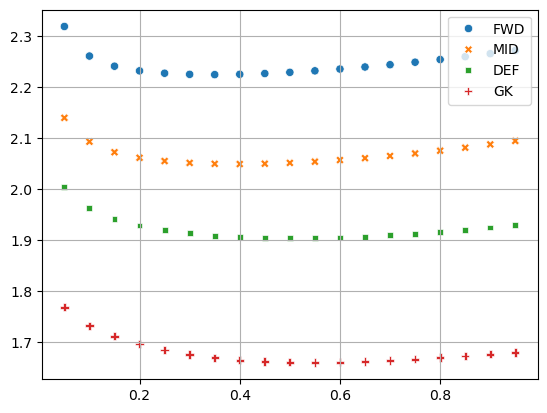

In [104]:
sns.scatterplot(rmse_df)
plt.grid()

0.4 looks like a good balance

In [93]:
rmse_df['GK'].idxmin(), rmse_df['FWD'].min()

(np.float64(0.5), np.float64(2.2247224801206182))

In [9]:
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb

for pos in ['FWD', 'MID', 'DEF', 'GK']:

    print(pos)
    ewma_merge_lag_pos = ewma_merge_lag.query('position==@pos').set_index(['full_name', 'gw'])

    X = ewma_merge_lag_pos[[
    'assists', 'bonus', 'bps', 'clean_sheets', 'goals_conceded',
    'goals_scored', 'influence', 'creativity', 'threat', 'ict_index',
    'minutes', 'ewma_total_points', 'ewma_team_goals',
    'ewma_nw_opponent_goals']]
    y = ewma_merge_lag_pos['nw_total_points']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

    params = {
            'max_depth': list(range(3,7)),  
        'min_child_weight': list(range(10,51)),
        'learning_rate':  [0.03, 0.15, 0.3, 0.45, 0.6],
        'subsample': stats.uniform(0.8, 0.1),
        'colsample_bytree': [0.8, 0.1]}

    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_reg.fit(X_train, y_train)

    xgb_cv = RandomizedSearchCV(xgb_reg, params, cv=3, scoring='neg_root_mean_squared_error',
                                random_state=999)

    xgb_cv.fit(X_train, y_train)
    xgb_best = xgb.XGBRegressor(objective='reg:squarederror')
    xgb_best.set_params(**xgb_cv.best_params_)

    xgb_best.fit(X_train, y_train)
    y_pred = xgb_best.predict(X_test)
    mse = root_mean_squared_error(y_test, y_pred)

    print(mse)

FWD


XGBoostError: [10:33:19] D:\bld\xgboost-split_1748292851775\work\src\data\data.cc:550: Check failed: valid: Label contains NaN, infinity or a value too large.